In [1]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import math 
import warnings
warnings.filterwarnings('ignore')

import random
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pickle

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset,ConcatDataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision import transforms as torchtrans 


from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# Helper Libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from torchvision.ops import nms  

ModuleNotFoundError: No module named 'engine'

In [29]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import json
import matplotlib.pyplot as plt

# PyTorch specific imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler

In [30]:
train_img_path = '/home/pranshu/project/data/potato/train/img_train'
train_ann_path = '/home/pranshu/project/data/potato/train/ann_train'

test_img_path = '/home/pranshu/project/data/potato/test/img_test'
test_ann_path = '/home/pranshu/project/data/potato/test/ann_test'

In [31]:
print(f"Training images: {len(os.listdir(train_img_path))}")
print(f"Training annotations: {len(os.listdir(train_ann_path))}")
print(f"Testing images: {len(os.listdir(test_img_path))}")
print(f"Testing annotations: {len(os.listdir(test_ann_path))}")

Training images: 1500
Training annotations: 1500
Testing images: 300
Testing annotations: 300


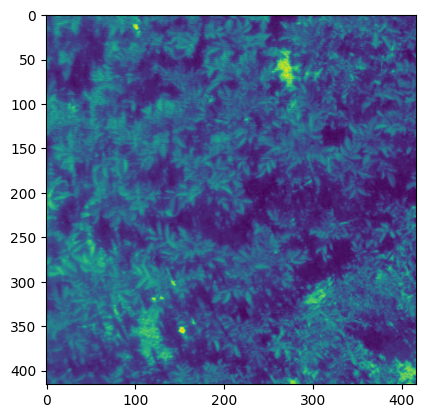

{'description': '', 'tags': [{'id': 5987918, 'tagId': 21506, 'name': 'image_id', 'value': 'Image_001', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2023-09-27T15:05:32.047Z', 'updatedAt': '2023-09-27T15:05:32.047Z'}], 'size': {'height': 416, 'width': 416}, 'objects': [{'id': 51099413, 'classId': 6462578, 'objectId': None, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2023-09-27T15:05:32.049Z', 'updatedAt': '2023-09-27T15:05:32.049Z', 'tags': [], 'classTitle': 'healthy', 'points': {'exterior': [[2, 2], [264, 255]], 'interior': []}}, {'id': 51099412, 'classId': 6462578, 'objectId': None, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2023-09-27T15:05:32.049Z', 'updatedAt': '2023-09-27T15:05:32.049Z', 'tags': [], 'classTitle': 'healthy', 'points': {'exterior': [[1, 262], [109, 413]], 'interior': []}}, {'id': 51099411, 'classId': 6462578, 'objectId': None, 'descript

In [32]:
def load_image_and_annotation(img_path, ann_path):
    with open(ann_path, 'r') as f:
        annotation = json.load(f)
    image = Image.open(img_path)
    return image, annotation

# Load and display a sample image and its annotation
sample_img_path = os.path.join(train_img_path, '/home/pranshu/project/data/potato/train/img_train/Green_Channel_Image_001.jpg')
sample_ann_path = os.path.join(train_ann_path, '/home/pranshu/project/data/potato/train/ann_train/Green_Channel_Image_001.jpg.json')

img, ann = load_image_and_annotation(sample_img_path, sample_ann_path)
plt.imshow(img)
plt.show()
print(ann)

In [33]:
def get_image_sizes(image_dir):
    sizes = []
    for file_name in os.listdir(image_dir):
        if file_name.endswith(('png', 'jpg', 'jpeg')):
            img_path = os.path.join(image_dir, file_name)
            with Image.open(img_path) as img:
                sizes.append(img.size)
    return sizes

train_sizes = get_image_sizes(train_img_path)
test_sizes = get_image_sizes(test_img_path)

print("Training image sizes:", train_sizes)
print("Testing image sizes:", test_sizes)

Training image sizes: [(416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (750, 750), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (750, 750), (416, 416), (416, 416), (416, 416), (750, 750), (416, 416), (750, 750), (750, 750), (416, 416), (750, 750), (416, 416), (750, 750), (416, 416), (750, 750), (750, 750), (750, 750), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (750, 750), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (750, 750), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (750, 750), (750, 750), (750, 750), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (750, 750), (416, 416), (416, 416), (416, 416), (416, 416), (416, 416), (416,

In [34]:
# Load the CSV file
df_train = pd.read_csv('/home/pranshu/project/data/potato/train/annotation_train.csv')

# Display the first few rows of the DataFrame
print(df_train.head())

                     file_name   x1   y1   x2   y2  category   area
0  Green_Channel_Image_212.jpg    2    0   70   86  stressed   5848
1  Green_Channel_Image_212.jpg   79    8  123   68  stressed   2640
2  Green_Channel_Image_212.jpg    0  114   67  277  stressed  10921
3  Green_Channel_Image_212.jpg    1  281   95  391  stressed  10340
4  Green_Channel_Image_212.jpg  107  229  238  332  stressed  13493


In [35]:
# Get the count of each category
category_counts = df_train['category'].value_counts()

# Display the result
print(category_counts)

category
stressed    11920
healthy      8200
Name: count, dtype: int64


In [36]:
# Check for null values in the entire DataFrame
null_counts = df_train.isnull().sum()

# Display the count of null values for each column
print(null_counts)

file_name    0
x1           0
y1           0
x2           0
y2           0
category     0
area         0
dtype: int64


In [37]:
unique_categories = df_train['category'].nunique()  # Counts unique non-null values
print(f"Number of unique categories: {unique_categories}")

Number of unique categories: 2


In [38]:
unique_category_list = df_train['category'].unique()
print(f"Unique categories: {unique_category_list}")

Unique categories: ['stressed' 'healthy']


In [39]:
# Load the CSV file
df_test = pd.read_csv('/home/pranshu/project/data/potato/test/annotation_test.csv')

# Display the first few rows of the DataFrame
print(df_test.head())

       file_name  x1   y1   x2   y2 category   area
0  Image_005.jpg  11    1  363  141  healthy  49280
1  Image_005.jpg   1  566  345  743  healthy  60888
2  Image_005.jpg   1  409  348  561  healthy  52744
3  Image_005.jpg   1  237  332  402  healthy  54615
4  Image_005.jpg  54  141  341  235  healthy  26978


In [40]:
# Get the count of each category
category_counts = df_test['category'].value_counts()

# Display the result
print(category_counts)

category
stressed    3670
healthy     2005
Name: count, dtype: int64


In [41]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20120 entries, 0 to 20119
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  20120 non-null  object
 1   x1         20120 non-null  int64 
 2   y1         20120 non-null  int64 
 3   x2         20120 non-null  int64 
 4   y2         20120 non-null  int64 
 5   category   20120 non-null  object
 6   area       20120 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5675 entries, 0 to 5674
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5675 non-null   object
 1   x1         5675 non-null   int64 
 2   y1         5675 non-null   int64 
 3   x2         5675 non-null   int64 
 4   y2         5675 non-null   int64 
 5   category   5675 non-null   object
 6   area       5675 non-null   int64 
dtypes: int64(5), object(2)
memory

In [42]:
# Display the shape of the DataFrame
print(f"DataFrame shape: {df_train.shape}")
# Display the shape of the DataFrame
print(f"DataFrame shape: {df_test.shape}")

DataFrame shape: (20120, 7)
DataFrame shape: (5675, 7)


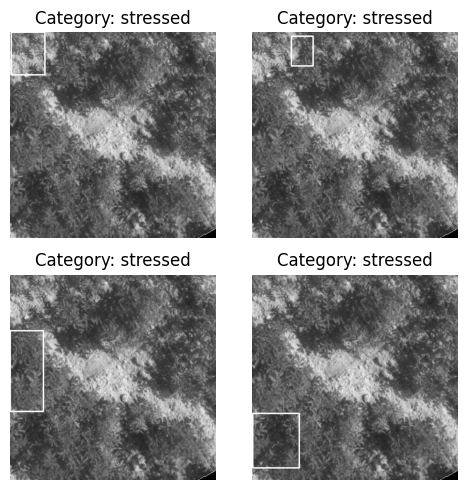

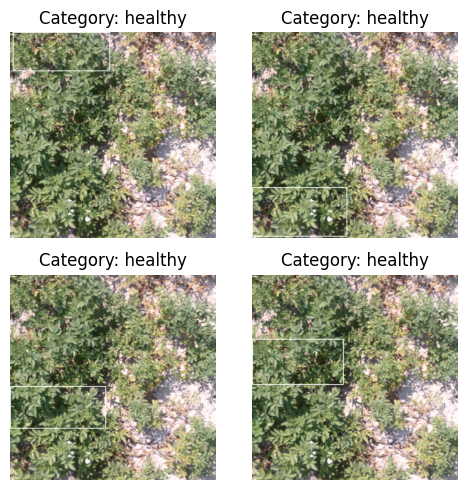

In [43]:
import matplotlib.pyplot as plt
import cv2
import os

def visualize_annotations(df, image_dir, num_images=4, grid_size=(2, 2), figsize=(8, 8), box_color=(0, 0, 255)):
    # Create a grid of subplots
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    axes = axes.flatten()

    for i in range(num_images):
        if i < len(df):
            # Select a row
            row = df.iloc[i]

            # Load the image
            img_path = os.path.join(image_dir, row['file_name'])
            img = cv2.imread(img_path)

            # Draw the bounding box with the specified color
            x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
            # Convert the coordinates to integers before passing them to cv2.rectangle
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), box_color, 2)


            # Display the image in the grid
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"Category: {row['category']}")
            axes[i].axis('off')  # Hide axes

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Use the function with a custom bounding box color (e.g., green)
visualize_annotations(df_train, '/home/pranshu/project/data/potato/train/img_train', num_images=4, grid_size=(2, 2), figsize=(5, 5), box_color=(255, 255, 255))
visualize_annotations(df_test, '/home/pranshu/project/data/potato/test/img_test', num_images=4, grid_size=(2, 2), figsize=(5, 5), box_color=(255, 255, 255))

In [44]:
# Load an image
img_path = '/home/pranshu/project/data/potato/train/img_train/Green_Channel_Image_001.jpg'
image = cv2.imread(img_path)

# Get the dimensions of the image
img_height, img_width = image.shape[:2]

print(f"Image width: {img_width}, Image height: {img_height}")

# Print the data types of the dimensions
print(f"Data type of img_width: {type(img_width)}")
print(f"Data type of img_height: {type(img_height)}")

Image width: 416, Image height: 416
Data type of img_width: <class 'int'>
Data type of img_height: <class 'int'>


In [45]:
# Function to convert bounding boxes and labels to masks
def convert_labels_to_masks(boxes, labels, img_shape, num_classes):
    # Ensure masks have the correct shape (num_classes, H, W)
    masks = torch.zeros((num_classes, img_shape[0], img_shape[1]), dtype=torch.float32)

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box.int()
        masks[label, y1:y2, x1:x2] = 1.0  # Set the mask area to 1 for the respective label

    return masks.permute(1, 2, 0)  # Return (H, W, C) for the masks

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, width, height):
        self.root_dir = root_dir
        self.width = width
        self.height = height
        self.classes = ['healthy', 'stressed']

        # Get the list of unique image filenames from the root directory
        self.image_filenames = os.listdir(root_dir)

        # Read the CSV file
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get image name
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        
        # Load image
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get original dimensions
        orig_height, orig_width = image.shape[:2]
        
        # Resize image
        image = cv2.resize(image, (self.width, self.height))
        
        # Normalize the image
        image = image / 255.0  # Normalize to [0, 1]

        # Compute scaling factors
        x_scale = self.width / orig_width
        y_scale = self.height / orig_height

        # Filter rows with the same image name
        same_image_rows = self.data[self.data['file_name'] == os.path.basename(img_name)]

        # Extract necessary information for bounding boxes
        boxes, labels = [], []
        for index, row in same_image_rows.iterrows():
            # Resize the bounding box coordinates according to the new image size
            x1 = row['x1'] * x_scale
            y1 = row['y1'] * y_scale
            x2 = row['x2'] * x_scale
            y2 = row['y2'] * y_scale
            boxes.append([x1, y1, x2, y2])
            labels.append(self.classes.index(row['category']))  # Should be 0 or 1 only

        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32).permute(0, 1, 2)  # (C, H, W)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Ensure num_classes is correctly set to 2 (healthy, stressed)
        num_classes = 2
        masks = convert_labels_to_masks(boxes, labels, (self.height, self.width), num_classes)

        # Create the target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,  # Add masks to the target dictionary
        }

        return image, target

# Paths for training and testing data
train_root_dir = "/home/pranshu/project/data/potato/train/img_train"
test_root_dir = "/home/pranshu/project/data/potato/test/img_test"
train_csv = "/home/pranshu/project/data/potato/train/annotation_train.csv"
test_csv = "/home/pranshu/project/data/potato/test/annotation_test.csv"

# Create the datasets
train_dataset = CustomDataset(csv_file=train_csv, root_dir=train_root_dir, height=672, width=672)
test_dataset = CustomDataset(csv_file=test_csv, root_dir=test_root_dir, height=672, width=672)

# Example of getting a sample from the dataset
image, target = train_dataset[0]
print("Image shape:", image.shape)
print("Masks shape:", target['masks'].shape)

# Check unique values in each mask channel
for i in range(target['masks'].shape[2]):
    print(f"Unique values in channel {i} (class {i}):", torch.unique(target['masks'][:, :, i]))

Image shape: torch.Size([672, 672, 3])
Masks shape: torch.Size([672, 672, 2])
Unique values in channel 0 (class 0): tensor([0., 1.])
Unique values in channel 1 (class 1): tensor([0., 1.])


In [46]:
print("Number of images in the dataset:", len(train_dataset))
print("Number of images in the dataset:", len(test_dataset))

Number of images in the dataset: 1500
Number of images in the dataset: 300


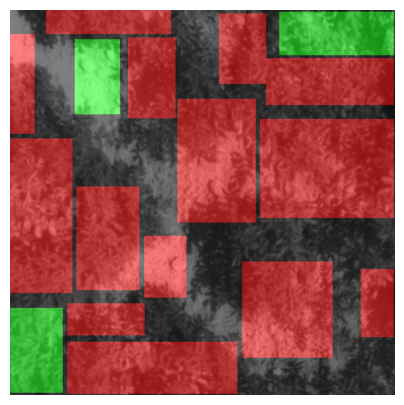

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

# Function to visualize masks on the image
def visualize_image_and_mask(image, masks, alpha=0.5):
    # Convert image from PyTorch tensor to NumPy array and move channels (C, H, W) -> (H, W, C)
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose(0, 1, 2)  # Convert from CHW to HWC

    # Convert mask from PyTorch tensor to NumPy array
    if isinstance(masks, torch.Tensor):
        masks = masks.numpy()

    # Ensure image values are between 0 and 1 for visualization
    image = image / 255.0 if image.max() > 1 else image

    # Create an overlay for visualization
    overlay = np.zeros_like(image)

    # Iterate over each mask for each class (assuming masks shape is (H, W, C) or (H, W))
    # Assign different colors for healthy and stressed classes
    class_colors = [(0, 1, 0), (1, 0, 0)]  # Green for healthy, Red for stressed
    for i in range(masks.shape[-1]):  # For each class mask (assuming masks shape is (H, W, C))
        mask = masks[..., i]  # Get mask for class i
        color = class_colors[i]

        # Color the mask area on the overlay
        overlay[mask > 0] = color

    # Blend the original image with the overlay mask
    blended = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)

    # Display the image with the overlayed mask
    plt.figure(figsize=(5, 5))
    plt.imshow(blended)
    plt.axis('off')  # Turn off axes for clean visualization
    plt.show()

# Example: Visualize a sample from your dataset
sample_idx = 10  # Choose any sample
image, target = train_dataset[sample_idx]

# Get the masks and image from the target
masks = target['masks']  # Should be in the shape (H, W, num_classes)

# Visualize the image and mask alignment
visualize_image_and_mask(image, masks)

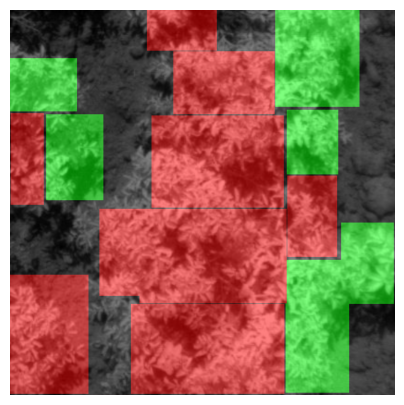

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

# Function to visualize masks on the image
def visualize_image_and_mask(image, masks, alpha=0.5):
    # Convert image from PyTorch tensor to NumPy array and move channels (C, H, W) -> (H, W, C)
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose(0, 1 , 2)  # Convert from CHW to HWC

    # Convert mask from PyTorch tensor to NumPy array
    if isinstance(masks, torch.Tensor):
        masks = masks.numpy()

    # Ensure image values are between 0 and 1 for visualization
    image = image / 255.0 if image.max() > 1 else image

    # Create an overlay for visualization
    overlay = np.zeros_like(image)

    # Iterate over each mask for each class (assuming masks shape is (H, W, C) or (H, W))
    # Assign different colors for healthy and stressed classes
    class_colors = [(0, 1, 0), (1, 0, 0)]  # Green for healthy, Red for stressed
    for i in range(masks.shape[-1]):  # For each class mask (assuming masks shape is (H, W, C))
        mask = masks[..., i]  # Get mask for class i
        color = class_colors[i]

        # Color the mask area on the overlay
        overlay[mask > 0] = color

    # Blend the original image with the overlay mask
    blended = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)

    # Display the image with the overlayed mask
    plt.figure(figsize=(5, 5))
    plt.imshow(blended)
    plt.axis('off')  # Turn off axes for clean visualization
    plt.show()

# Example: Visualize a sample from your dataset
sample_idx = 10  # Choose any sample
image, target = test_dataset[sample_idx]

# Get the masks and image from the target
masks = target['masks']  # Should be in the shape (H, W, num_classes)

# Visualize the image and mask alignment
visualize_image_and_mask(image, masks)


In [49]:
from typing import List, Tuple, Dict
import torch
def collate_fn(batch: List[Tuple[torch.Tensor, Dict[str, torch.Tensor]]]) -> Tuple[torch.Tensor, torch.Tensor]:
    images, targets = zip(*batch)

    # Change shape from (H, W, C) to (C, H, W)
    images = torch.stack([img.permute(2, 0, 1) for img in images], dim=0)  # Now it's (N, C, H, W)

    masks = []
    num_classes = 2  # healthy and stressed

    for target in targets:
        boxes = target['boxes']
        labels = target['labels']
        mask = convert_labels_to_masks(boxes, labels, (672, 672), num_classes)
        masks.append(mask)

    masks = torch.stack(masks) if masks else torch.empty((0, num_classes, 672, 672), dtype=torch.float32)

    return images, masks  # Ensure output shapes are consistent

In [50]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=4)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import math

class GaussianBlur(nn.Module):
    def __init__(self, kernel_size=5, sigma=1.0, channels=2):
        super(GaussianBlur, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma

        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_coord = torch.arange(kernel_size)
        x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

        mean = (kernel_size - 1)/2.
        variance = sigma**2.

        # Calculate the 2D Gaussian kernel
        gaussian_kernel = (1./(2.*math.pi*variance)) * \
                          torch.exp(
                              -torch.sum((xy_grid - mean)**2., dim=-1) / \
                              (2*variance)
                          )

        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

        # Reshape to depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

        self.register_buffer('weight', gaussian_kernel)
        self.groups = channels
        self.padding = kernel_size // 2

    def forward(self, x):
        return F.conv2d(x, self.weight, groups=self.groups, padding=self.padding)

class RetinaUNetAgModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RetinaUNetAgModel, self).__init__()

        # Load a pre-trained ResNet50 model
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove the final layers

        # Feature Pyramid Network (FPN) layers
        self.fpn = nn.ModuleList([
            nn.Conv2d(2048, 256, kernel_size=1),  # C5
            nn.Conv2d(1024, 256, kernel_size=1),  # C4
            nn.Conv2d(512, 256, kernel_size=1),   # C3
            nn.Conv2d(256, 256, kernel_size=1),   # C2
        ])

        # Upconvolution layers with dilation
        self.upconv = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=3, padding=2, dilation=2),  # Dilation to capture more context
            nn.Conv2d(256, 256, kernel_size=3, padding=2, dilation=2),
        ])

        # Final output layer
        self.final_conv = nn.Conv2d(256, num_classes, kernel_size=1)

        # Add custom Gaussian blur layer for post-processing smoothing
        self.smoothing = GaussianBlur(kernel_size=5, sigma=1.0, channels=num_classes)

    def forward(self, x):
        # Encoder
        c2 = self.encoder[0:5](x)   # Extract features
        c3 = self.encoder[5:6](c2)
        c4 = self.encoder[6:7](c3)
        c5 = self.encoder[7:8](c4)

        # FPN
        p5 = self.fpn[0](c5)
        p4 = self.fpn[1](c4)
        p3 = self.fpn[2](c3)
        p2 = self.fpn[3](c2)

        # Upsampling with residual connections
        p5_upsampled = F.interpolate(p5, scale_factor=2, mode='nearest')  # Removed align_corners
        p5 = self.upconv[0](p5_upsampled + p4)
        p5 = F.relu(p5)

        p4_upsampled = F.interpolate(p5, scale_factor=2, mode='nearest')  # Removed align_corners
        p4 = self.upconv[1](p4_upsampled + p3)
        p4 = F.relu(p4)

        # Final output, ensuring the size is 672x672
        output = self.final_conv(p4)  # Output shape [B, C, 672, 672]
        output = F.interpolate(output, size=(672, 672), mode='nearest')  # Removed align_corners

        # Apply Gaussian smoothing to reduce over-smoothing artifacts
        output = self.smoothing(output)

        # Convert output from [B, C, H, W] to [B, H, W, C] if necessary
        # Note: Most loss functions and evaluation metrics expect [B, C, H, W]
        # If you need [B, H, W, C], ensure your downstream code handles it correctly
        output = output.permute(0, 2, 3, 1)  # Rearranging to [B, H, W, C]

        return output
# Instantiate the model
model = RetinaUNetAgModel(num_classes=2)
print(model)

/home/pranshu/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pranshu/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaUNetAgModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [52]:
class Checkpoint:
    def __init__(self, filepath, monitor='loss', mode='min'):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_score = float('inf') if mode == 'min' else float('-inf')

    def save(self, model, score):
        if (self.mode == 'min' and score < self.best_score) or (self.mode == 'max' and score > self.best_score):
            torch.save(model.state_dict(), self.filepath)
            self.best_score = score
            print(f'Saved model with {self.monitor}: {score:.4f}')

checkpoint_filepath = '/home/pranshu/project/models/unet.h5'  # Define your checkpoint filepath
checkpoint = Checkpoint(filepath=checkpoint_filepath, monitor='loss', mode='min')

In [53]:
# Load the model weights if resuming training
if os.path.exists(checkpoint_filepath):
    try:
        model.load_state_dict(torch.load(checkpoint_filepath))
        model.train()  # Set the model to evaluation mode if not training
        print("Checkpoint loaded successfully, resuming training.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
else:
    print("No checkpoint found, starting training from scratch.")

No checkpoint found, starting training from scratch.


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)  # Apply sigmoid to get probabilities
        
        # Use .reshape() instead of .view()
        predictions = predictions.reshape(-1)
        targets = targets.reshape(-1)
        
        intersection = (predictions * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        return 1 - dice_coeff

# BCE + Dice Loss combined
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()  # BCE with logits
        self.dice = DiceLoss()  # Dice Loss

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        return bce_loss + dice_loss  # Combine the two losses

In [55]:
# Assuming the retina_unet_ag_model function has been defined as per your earlier request
#model = retina_unet_ag_model(input_shape=(672, 672, 3), num_classes=2)  # 2 classes for binary classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Move the model to the GPU if available

# Define loss function and optimizer
criterion = BCEDiceLoss()  # For binary cross-entropy with logits (suitable for binary classification)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
import torch
import itertools  # For cycling through the dataloader
from tqdm import tqdm  # Optional, for progress display

num_epochs = 20
steps_per_epoch = 500  # Set the desired number of steps per epoch
save_interval = 10  # Adjust this as needed

# Create a cycle for repeating batches from the dataloader
train_dataloader_cycle = itertools.cycle(train_dataloader)

for epoch in range(num_epochs):
    running_loss = 0.0  # To track the cumulative loss over the epoch
    
    # Progress bar (optional)
    with tqdm(total=steps_per_epoch, desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
        for step in range(steps_per_epoch):
            # Get the next batch (cycling through the dataloader)
            batch = next(train_dataloader_cycle)
            
            # Extract images and masks from the batch
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            # Ensure images are in the shape [B, C, H, W]
            if images.dim() == 4 and images.shape[1] != 3:
                images = images.permute(0, 3, 1, 2)  # [B, H, W, C] to [B, C, H, W]
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            running_loss += loss.item()

            # Print the current step loss (Optional: print or log periodically)
            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

        # End of epoch, calculate and print average loss for the epoch
        avg_loss = running_loss / steps_per_epoch
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

# Optionally save the final model after training
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_2.pth')
print('Final model saved.')

Epoch 1/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.53it/s, Loss=0.591]


Epoch 1, Average Loss: 0.926016666173935


Epoch 2/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.641]


Epoch 2, Average Loss: 0.6508905099034309


Epoch 3/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.617]


Epoch 3, Average Loss: 0.5366418522596359


Epoch 4/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.371]


Epoch 4, Average Loss: 0.4523065105676651


Epoch 5/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.421]


Epoch 5, Average Loss: 0.3953532477021217


Epoch 6/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.351]


Epoch 6, Average Loss: 0.34914153459668157


Epoch 7/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.217]


Epoch 7, Average Loss: 0.30197350487113


Epoch 8/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.291]


Epoch 8, Average Loss: 0.2710117962062359


Epoch 9/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.276]


Epoch 9, Average Loss: 0.24761847218871116


Epoch 10/20: 100%|█████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.21]


Epoch 10, Average Loss: 0.24999062085151671


Epoch 11/20: 100%|████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.271]


Epoch 11, Average Loss: 0.26117442214488984


Epoch 12/20: 100%|████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.217]


Epoch 12, Average Loss: 0.22207073584198952


Epoch 13/20: 100%|████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.135]


Epoch 13, Average Loss: 0.19906512561440468


Epoch 14/20: 100%|████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.184]


Epoch 14, Average Loss: 0.17932626071572305


Epoch 15/20: 100%|████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.177]


Epoch 15, Average Loss: 0.1789480884373188


Epoch 16/20: 100%|████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.184]


Epoch 16, Average Loss: 0.19677653723955155


Epoch 17/20: 100%|████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.209]


Epoch 17, Average Loss: 0.2368857693374157


Epoch 18/20: 100%|████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s, Loss=0.173]


Epoch 18, Average Loss: 0.17513935546576978


Epoch 19/20:  99%|███████████████████████████████████████████████████████▎| 494/500 [01:27<00:01,  5.68it/s, Loss=0.154]

In [56]:
# Load the saved model
model_path = 'model_2.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

/tmp/ipykernel_429500/2166011832.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


RetinaUNetAgModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [57]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import torchvision.ops as ops

# Dice Score Coefficient function
def dice_score_coefficient(true, pred, smooth=1e-2):
    intersection = np.sum(true * pred)
    return (2. * intersection + smooth) / (np.sum(true) + np.sum(pred) + smooth)

# Non-Maximum Suppression (NMS) Function
def apply_nms(boxes, scores, threshold=0.3):
    keep_indices = ops.nms(boxes, scores, threshold)
    return keep_indices

def filter_boxes_with_nms(predictions, conf_thresh=0.7, nms_thresh=0.3):
    boxes = predictions['boxes']
    scores = predictions['scores']
    
    # Filter out boxes with low confidence scores
    mask = scores > conf_thresh
    boxes = boxes[mask]
    scores = scores[mask]

    if len(boxes) == 0:
        return torch.empty((0, 4)), torch.empty((0,))
    
    # Apply Non-Maximum Suppression (NMS)
    keep = apply_nms(boxes, scores, nms_thresh)
    
    # Return only the boxes and scores that survived NMS
    return boxes[keep], scores[keep]

# Function to evaluate the model
def evaluate_model_pytorch(model, dataloader, device, threshold=0.5, num_classes=2):
    all_true_masks = []
    all_pred_masks = []
    all_images = []  # Store the original images for visualization

    print(f'Starting evaluation... Total batches: {len(dataloader)}')

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (images, true_masks) in enumerate(dataloader):
            images = images.to(device)  # Move images to the appropriate device
            true_masks = true_masks.to(device)  # Move masks to the appropriate device

            # Predict masks using the PyTorch model
            pred_masks = model(images)

            # Apply sigmoid activation for binary classification
            pred_masks = torch.sigmoid(pred_masks)  # Apply sigmoid for binary segmentation

            # Apply thresholding to get binary predictions
            pred_masks = (pred_masks > threshold).float()  # Convert to float for binary masks

            # Convert true masks and predicted masks to numpy
            true_masks = true_masks.cpu().numpy()  # Move to CPU and convert to numpy
            pred_masks = pred_masks.cpu().numpy()  # Move to CPU and convert to numpy
            images = images.cpu().numpy()  # Move images to CPU for visualization

            # Append the masks and images to the lists
            all_true_masks.append(true_masks)
            all_pred_masks.append(pred_masks)
            all_images.append(images)

            # Print progress
            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(dataloader):
                print(f'Evaluating batch {batch_idx + 1}/{len(dataloader)}')

    # Concatenate all collected masks and images
    all_true_masks = np.concatenate(all_true_masks, axis=0)
    all_pred_masks = np.concatenate(all_pred_masks, axis=0)
    all_images = np.concatenate(all_images, axis=0)

    # Initialize metrics dictionaries
    class_metrics = {}

    for class_idx in range(num_classes):
        # Create binary arrays for the current class
        true_binary = (all_true_masks == class_idx).astype(int)
        pred_binary = (all_pred_masks == class_idx).astype(int)

        # Flatten arrays
        true_flat = true_binary.flatten()
        pred_flat = pred_binary.flatten()

        # Compute metrics for the current class
        accuracy = accuracy_score(true_flat, pred_flat)
        precision = precision_score(true_flat, pred_flat, zero_division=0)
        recall = recall_score(true_flat, pred_flat, zero_division=0)
        iou = np.sum(np.logical_and(true_flat, pred_flat)) / np.sum(np.logical_or(true_flat, pred_flat))
        dsc = dice_score_coefficient(true_flat, pred_flat)

        # Store metrics in the dictionary
        class_metrics[class_idx] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'iou': iou,
            'dsc': dsc
        }

    print('Evaluation complete.')
    
    # Return class metrics, all true masks, predicted masks, and images for visualization
    return class_metrics, all_true_masks, all_pred_masks, all_images

In [58]:
def visualize_predictions(images, true_masks, pred_masks, index):
    """
    Visualizes the original image, true mask, and predicted mask for both class 0 and class 1.

    Parameters:
        images (np.ndarray): Array of input images.
        true_masks (np.ndarray): Array of true masks.
        pred_masks (np.ndarray): Array of predicted masks.
        index (int): Index of the image to visualize.
    """
    # Select the image and corresponding masks
    image = images[index]
    true_mask = true_masks[index]
    pred_mask = pred_masks[index]

    # Convert the image from CHW to HWC format for visualization
    image = np.transpose(image, (1, 2, 0))  # From (C, H, W) to (H, W, C)

    # Select the masks for class 0 and class 1
    true_mask_class0 = true_mask[..., 0]  # Assuming the first channel is for class 0
    pred_mask_class0 = pred_mask[..., 0]  # Same for predicted mask of class 0
    true_mask_class1 = true_mask[..., 1]  # Assuming the second channel is for class 1
    pred_mask_class1 = pred_mask[..., 1]  # Same for predicted mask of class 1

    # Plotting
    plt.figure(figsize=(16, 8))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # True Mask for Class 0
    plt.subplot(2, 3, 2)
    plt.imshow(true_mask_class0.squeeze(), cmap='gray')  # Display only the mask for class 0
    plt.title("True Mask (Class 0)")
    plt.axis("off")

    # Predicted Mask for Class 0
    plt.subplot(2, 3, 3)
    plt.imshow(pred_mask_class0.squeeze(), cmap='gray')  # Display only the mask for class 0
    plt.title("Predicted Mask (Class 0)")
    plt.axis("off")

    # True Mask for Class 1
    plt.subplot(2, 3, 5)
    plt.imshow(true_mask_class1.squeeze(), cmap='gray')  # Display only the mask for class 1
    plt.title("True Mask (Class 1)")
    plt.axis("off")

    # Predicted Mask for Class 1
    plt.subplot(2, 3, 6)
    plt.imshow(pred_mask_class1.squeeze(), cmap='gray')  # Display only the mask for class 1
    plt.title("Predicted Mask (Class 1)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [59]:
#Evaluate the model
class_metrics, all_true_masks, all_pred_masks, all_images = evaluate_model_pytorch(model, test_dataloader, device)

Starting evaluation... Total batches: 75
Evaluating batch 10/75
Evaluating batch 20/75
Evaluating batch 30/75
Evaluating batch 40/75
Evaluating batch 50/75
Evaluating batch 60/75
Evaluating batch 70/75
Evaluating batch 75/75
Evaluation complete.


In [60]:
# Print out class metrics
for class_idx, metrics in class_metrics.items():
    print(f"\nClass {class_idx} metrics:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.capitalize()}: {metric_value:.4f}")


Class 0 metrics:
Accuracy: 0.7485
Precision: 0.7716
Recall: 0.8391
Iou: 0.6722
Dsc: 0.8039

Class 1 metrics:
Accuracy: 0.7485
Precision: 0.7020
Recall: 0.6042
Iou: 0.4809
Dsc: 0.6495


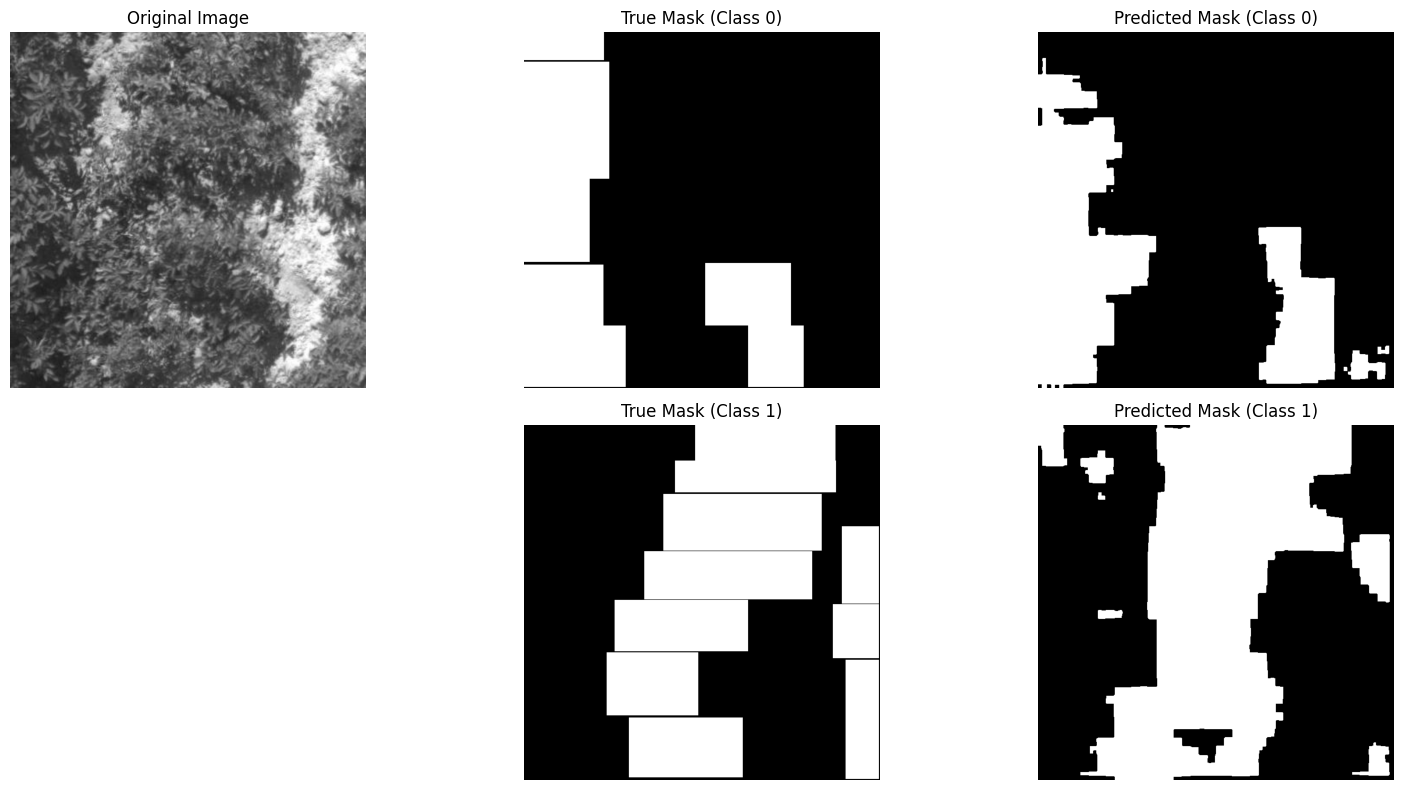

In [61]:
# Visualize predictions for a specific index
index = 1  # You can change this to visualize different images
visualize_predictions(all_images, all_true_masks, all_pred_masks, index)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_labels_colored(images, true_masks, pred_masks, index=0, alpha=0.4):
    """
    Converts the true and predicted masks into class labels and visualizes them with color-coded labels.

    Parameters:
        images (np.ndarray): Array of input images.
        true_masks (np.ndarray): Array of true masks.
        pred_masks (np.ndarray): Array of predicted masks.
        index (int): Index of the image to visualize.
        alpha (float): Transparency level for overlaying the labels onto the original image.
    """
    # Define colors for the labels
    label_colors = np.array([
        [255, 255, 0],    # Yellow for class 0 (healthy)
        [255, 0, 0]     # Red for class 1 (stressed)
    ], dtype=np.uint8)

    # Select the image and corresponding masks
    image = images[index]
    true_mask = true_masks[index]
    pred_mask = pred_masks[index]

    # Convert the image from CHW to HWC format for visualization
    image = np.transpose(image, (1, 2, 0))  # From (C, H, W) to (H, W, C)
    
    # Normalize the image values between 0 and 1 for plotting if needed
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Convert masks to class labels (binary masks in this case)
    true_labels = np.argmax(true_mask, axis=-1)  # Convert one-hot true mask to class labels
    pred_labels = np.argmax(pred_mask, axis=-1)  # Convert predicted mask to class labels

    # Convert true and predicted labels to RGB color maps
    true_color_mask = label_colors[true_labels]
    pred_color_mask = label_colors[pred_labels]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Overlay True Label Map
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(true_color_mask, alpha=alpha)  # Overlay with transparency
    plt.title("True Labels (Yellow: Healthy, Red: Stressed)")
    plt.axis("off")

    # Overlay Predicted Label Map
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(pred_color_mask, alpha=alpha)  # Overlay with transparency
    plt.title("Predicted Labels (Yellow: Healthy, Red: Stressed)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

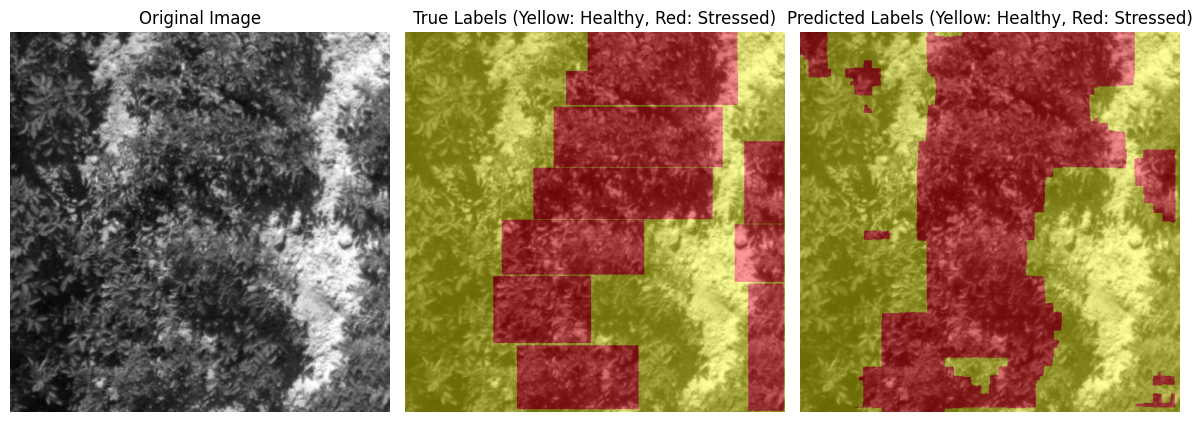

In [63]:
# Visualize the true and predicted label maps with color coding
index = 1  # You can change this to visualize different images
visualize_labels_colored(all_images, all_true_masks, all_pred_masks, index)